In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Print the shapes of the training and testing data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [4]:
# Preprocess the data
# Normalize pixel values to the range [0, 1]
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [13]:
# Select a subset of labeled data for semi-supervised learning
samples_per_class = 200  # Number of labeled samples per class
num_classes = 10  # Total number of classes

# Labeled data selection
labeled_indices = []
for class_label in range(num_classes):
    # Find indices for the current class
    class_indices = np.where(y_train == class_label)[0]
    # Randomly select specified number of samples for the class
    selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    labeled_indices.append(selected_indices)

# Combine labeled indices from all classes
labeled_indices = np.concatenate(labeled_indices)

# Split data into labeled and unlabeled subsets
x_labeled = x_train[labeled_indices]
y_labeled = y_train_onehot[labeled_indices]
unlabeled_indices = np.setdiff1d(np.arange(len(y_train)), labeled_indices)
x_unlabeled = x_train[unlabeled_indices]

# Output shapes for verification
print(f"x_labeled shape: {x_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"x_unlabeled shape: {x_unlabeled.shape}")

x_labeled shape: (2000, 28, 28, 1)
y_labeled shape: (2000, 10)
x_unlabeled shape: (58000, 28, 28, 1)


In [21]:
# Validation Split for Labeled Data
x_train_labeled, x_val, y_train_labeled, y_val = train_test_split(
    x_labeled, y_labeled, test_size=0.5, random_state=200, stratify=y_labeled
)

CNN Model

In [22]:
def create_model(K=10, l2_lambda=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same',
               input_shape=(28, 28, 1),
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dropout(0.2),

        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),

        Dense(K, activation='softmax', kernel_regularizer=l2(l2_lambda))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_model()
model.summary()

c:\Users\adity\OneDrive\Desktop\Sem 1\Deep Learning\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,586 (1.79 MB)

 Trainable params: 468,202 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train_labeled, y_train_labeled,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.2726 - val_accuracy: 0.9630 - val_loss: 0.4728 - learning_rate: 5.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9947 - loss: 0.2771 - val_accuracy: 0.9600 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.2660 - val_accuracy: 0.9610 - val_loss: 0.4650 - learning_rate: 5.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9985 - loss: 0.2645 - val_accuracy: 0.9610 - val_loss: 0.4612 - learning_rate: 5.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9992 - loss: 0.2608 - val_accuracy: 0.9600 - val_loss: 0.4553 - learning_rate: 5.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9993 - loss: 0.2589 - val_accuracy: 0.9600 - val_loss: 0.4509 - learning_rate: 5.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 

In [27]:
# Get training and validation metrics from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

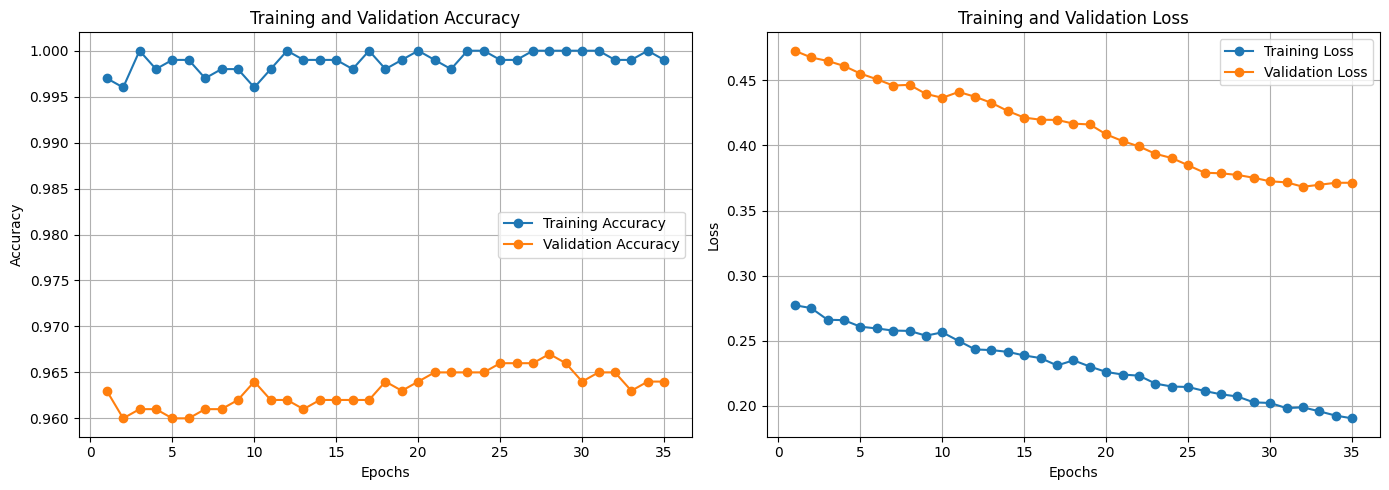

In [28]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


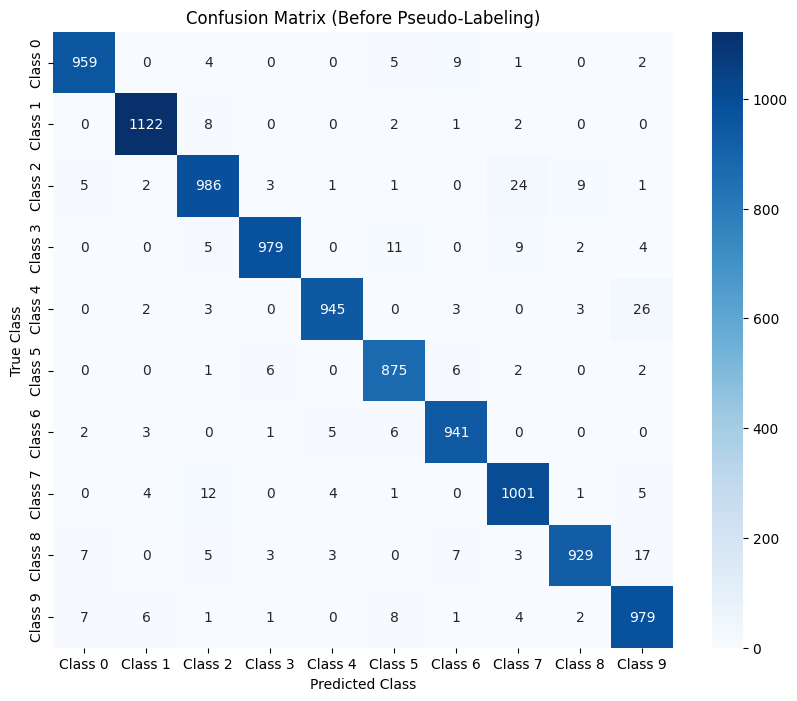

Classification Report (Before Pseudo-Labeling):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.96      0.97       982
           5       0.96      0.98      0.97       892
           6       0.97      0.98      0.98       958
           7       0.96      0.97      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.94      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [29]:
# Generate predictions and evaluate the model before pseudo-labeling
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title("Confusion Matrix (Before Pseudo-Labeling)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Print the classification report
print("Classification Report (Before Pseudo-Labeling):")
print(classification_report(y_true, y_pred_classes))

In [30]:
# Define a function to plot sample predictions
def plot_sample_predictions(model, x_data, y_true, class_names=None, num_samples=10):
    indices = np.random.choice(len(x_data), num_samples, replace=False)  # Randomly select samples for visualization
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = x_data[idx]
        true_label = y_true[idx]
        pred_label = np.argmax(model.predict(img[np.newaxis,...]), axis=1)[0]

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if class_names:
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        else:
            plt.title(f"P:{pred_label}, T:{true_label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


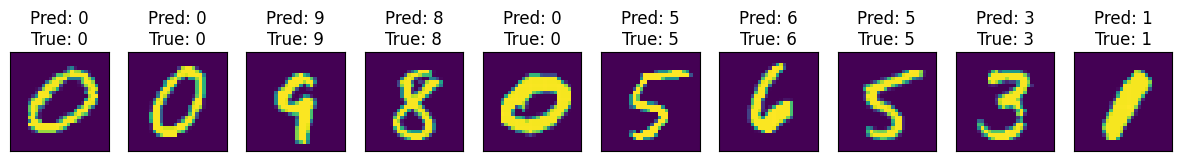

In [31]:
# MNIST class names
class_names = [str(i) for i in range(10)]  # ["0", "1", "2", ..., "9"]

plot_sample_predictions(model, x_test, y_true, class_names, num_samples=10)


In [32]:
# Define a function to generate pseudo-labels
confidence_threshold = 0.97 # Confidence threshold for pseudo-labeling

def generate_pseudo_labels(model, x_unlabeled, confidence_threshold):
    predictions = model.predict(x_unlabeled)
    confidences = np.max(predictions, axis=1)
    pseudo_labels = np.argmax(predictions, axis=1)
    high_confidence_indices = np.where(confidences >= confidence_threshold)[0]
    x_unlabeled_high_confidence = x_unlabeled[high_confidence_indices]
    y_unlabeled_high_confidence = tf.keras.utils.to_categorical(pseudo_labels[high_confidence_indices], 10)
    return x_unlabeled_high_confidence, y_unlabeled_high_confidence

# Generate pseudo-labels for the unlabeled data
x_pseudo, y_pseudo = generate_pseudo_labels(model, x_unlabeled, confidence_threshold)

1813/1813 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step


In [37]:
print("x_combined:", x_pseudo.shape)
print("y_combined:", y_pseudo.shape)

x_combined: (54606, 28, 28, 1)
y_combined: (54606, 10)


In [38]:
# Combine labeled and pseudo-labeled data for training
x_combined = np.concatenate([x_train_labeled, x_pseudo])
y_combined = np.concatenate([y_train_labeled, y_pseudo])

# Print the shapes of the combined dataset
print("Combined dataset shapes after pseudo-labeling:")
print("x_combined:", x_combined.shape)
print("y_combined:", y_combined.shape)

Combined dataset shapes after pseudo-labeling:
x_combined: (55606, 28, 28, 1)
y_combined: (55606, 10)


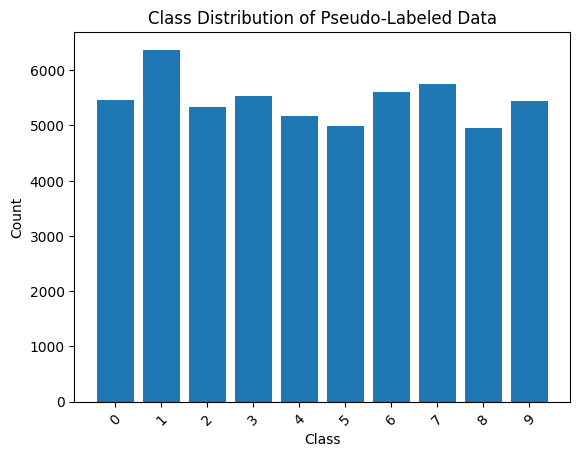

In [39]:
# Optional: Visualize class distribution after pseudo-labeling
# Count how many pseudo-labels per class were added
pseudo_labels_int = np.argmax(y_pseudo, axis=1)
unique, counts = np.unique(pseudo_labels_int, return_counts=True)
plt.bar([class_names[i] for i in unique], counts)
plt.xticks(rotation=45)
plt.title("Class Distribution of Pseudo-Labeled Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [40]:
# Train the model with the combined dataset
history = model.fit(
    x_combined, y_combined,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy (After Pseudo-Labeling): {test_accuracy:.2f}")

Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9974 - loss: 0.1931 - val_accuracy: 0.9700 - val_loss: 0.3193 - learning_rate: 2.5000e-04
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 110s 127ms/step - accuracy: 0.9983 - loss: 0.1557 - val_accuracy: 0.9770 - val_loss: 0.2536 - learning_rate: 2.5000e-04
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 115s 132ms/step - accuracy: 0.9985 - loss: 0.1184 - val_accuracy: 0.9720 - val_loss: 0.2256 - learning_rate: 2.5000e-04
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 90s 104ms/step - accuracy: 0.9983 - loss: 0.0861 - val_accuracy: 0.9680 - val_loss: 0.2262 - learning_rate: 2.5000e-04
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 116s 134ms/step - accuracy: 0.9973 - loss: 0.0660 - val_accuracy: 0.9750 - val_loss: 0.1701 - learning_rate: 2.5000e-04
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 119s 137ms/step - accuracy: 0.9968 - loss: 0.0552 - val_accuracy: 0.9700 - val_loss: 0.1726 - learning_rate: 2.5000e-04
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 1

In [41]:
# Save the final model
model.save('best_cnn_model_with_pseudo_labels.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


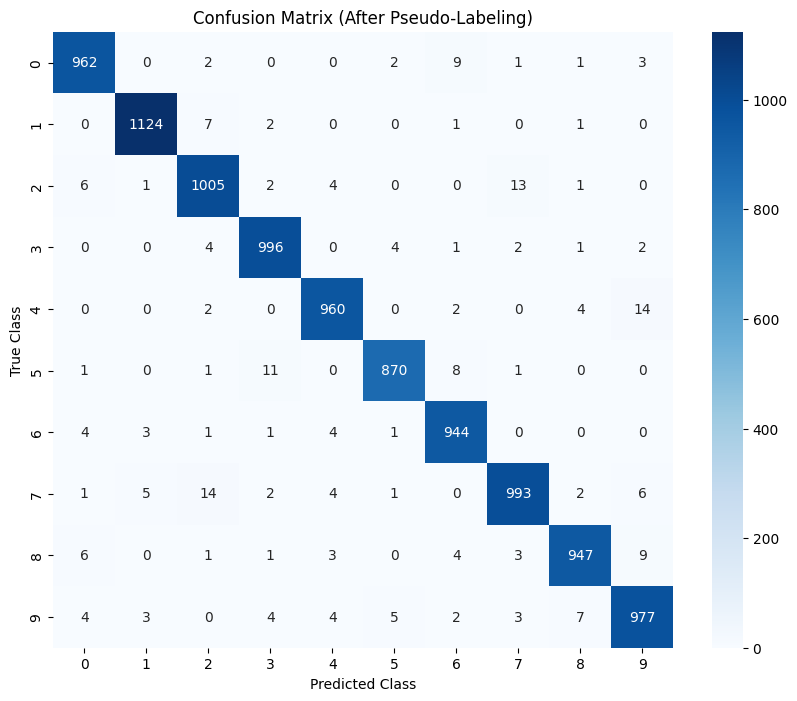

Classification Report (After Pseudo-Labeling):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 

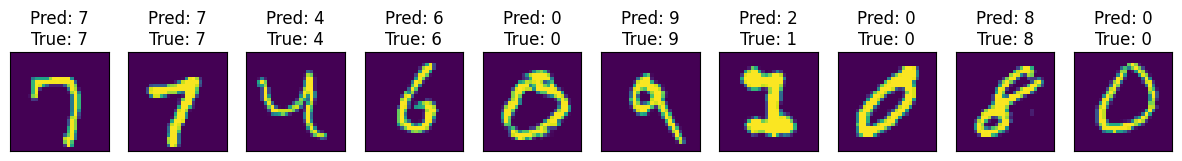

In [42]:
# Generate predictions and evaluate the model after pseudo-labeling
y_pred_after = model.predict(x_test)
y_pred_classes_after = np.argmax(y_pred_after, axis=1)

# Generate and plot the confusion matrix after pseudo-labeling
cm_after = confusion_matrix(y_true, y_pred_classes_after)
plt.figure(figsize=(10,8))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (After Pseudo-Labeling)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Print the classification report after pseudo-labeling
print("Classification Report (After Pseudo-Labeling):")
print(classification_report(y_true, y_pred_classes_after))

# Optional: Visualize sample predictions again after pseudo-labeling
plot_sample_predictions(model, x_test, y_true, class_names, num_samples=10)

In [45]:

from sklearn.metrics import classification_report
import pandas as pd

# Get classification reports before and after pseudo-labeling
report_before = classification_report(y_true, y_pred_classes, output_dict=True)
report_after = classification_report(y_true, y_pred_classes_after, output_dict=True)

# Extract key metrics for each class and overall averages
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
comparison_data = {}

for metric in metrics:
    if metric == 'accuracy':
        comparison_data[metric] = {
            "Before": report_before[metric],
            "After": report_after[metric],
            "Improvement": report_after[metric] - report_before[metric]
        }
    else:
        comparison_data[metric] = {
            "Before": report_before['weighted avg'][metric],
            "After": report_after['weighted avg'][metric],
            "Improvement": report_after['weighted avg'][metric] - report_before['weighted avg'][metric]
        }

# Convert comparison data to a DataFrame
comparison_df = pd.DataFrame(comparison_data).T

# Display the table
print(comparison_df)

             Before     After  Improvement
accuracy   0.971600  0.977800     0.006200
precision  0.971790  0.977825     0.006035
recall     0.971600  0.977800     0.006200
f1-score   0.971617  0.977797     0.006179
